# Working with NFT data

## Piotr Wycech

### In this project, we analyze "Tales of Terra" NFTs. They are in the form of cards, which contain following features: token id, name, description, Author, GMI Level, Card Rarity and Series. Our goal is to retrieve information about tfts itself, propose a way to rate their rarity and get information about the transactions which involved NFTs, as well as visualize the results. This NFT is available through following link:

https://randomearth.io/collections/terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w

### Importing all necessary packages:

In [1]:
import requests
import time
import json
import os
import sys
import inspect
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
plt.figure(figsize=(12, 9), dpi=80)

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

### Loading first set of data (offset = 0)

In [2]:
# Loading a data from URL containing information about NFT:
URL = "https://fcd.terra.dev/v1/txs?offset=0&limit=100&account=terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w"
page = requests.get(URL)

# Creating a directory in which we contain the data:
os.chdir(sys.path[0])
if not os.path.exists('./data_folder'):
    os.makedirs('./data_folder') # Creating a directory in case it doesn't exist
[f.unlink() for f in Path("./data_folder").glob("*") if f.is_file()]  # Deleting all leftover files in directory
os.chdir('./data_folder')

# Loading first set of data into file
if os.path.exists("dane0.txt"):
    open('data0.txt', 'w').close()
file = open("data0.txt", "w")
file.write(page.text)
file.close()

with open('data0.txt') as json_file:
    data = json.load(json_file)

### Loading data from remaining offsets:

In [3]:
data_files = 1
try:
    while data['next']: # If data contains category "next", it means that there are more offsets containing information
        URL = "https://fcd.terra.dev/v1/txs?offset={0}&limit=100&account=terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w".format(data['next'])
        page = requests.get(URL)
        # Loading sets of data into files
        file = open("data{0}.txt".format(data_files), "w")
        file.write(page.text)
        file.close()
        with open('data{0}.txt'.format(data_files)) as json_file:
            data = json.load(json_file)
        data_files += 1
        time.sleep(1)
except:
    pass

### Saving only those messages that are 'execute_msg' - they contain data that we need:

In [4]:
tx = {} # Directory containing all text within one text block
msgs = {} # Directory containing all types of messages within text block
list_of_msgs = [] # List containing only execute messages - they contain data that we will need
for i in range(data_files):
    with open('data{0}.txt'.format(i)) as json_file:
        data = json.load(json_file)
        for i in range(len(data['txs'])):
            tx["{0}".format(i)] = data['txs'][i]
            messages = tx["{0}".format(i)]['tx']['value']['msg']
            for m in messages:
                if "execute_msg" in m['value'].keys():
                    msgs = { 'type':m['type'],
                        'hash_id':tx["{0}".format(i)]['txhash'],
                        'exe_msg':m['value']['execute_msg'] }
                    list_of_msgs.append(msgs)

### Saving mint nfts - unique tokens on a blockchain. Only after minting an NFT is the digital collectible stored on the blockchain.

In [8]:
mint_nfts = []
for num in range(len(list_of_msgs)):
    if 'mint_nft' in list_of_msgs[num]['exe_msg']:
        mint_nfts.append(list_of_msgs[num]['exe_msg'])

### Saving execute orders

In [9]:
execute_orders = []
for num in range(len(list_of_msgs)):
    if 'execute_order' in list_of_msgs[num]['exe_msg']:
        execute_orders.append(list_of_msgs[num]['exe_msg'])

### Creating dataframe with collected information about NFTs:

In [22]:
df_mint = pd.DataFrame()
for k in range(len(mint_nfts)):
    df = pd.DataFrame.from_dict(mint_nfts[k]['mint_nft']['extension'])
    df = df.drop(['attributes', 'animation_url'], axis=1)
    df = df.drop(labels=[1, 2, 3], axis=0) # Dropping non-important information
    # Putting all values from 'attributes' in 'extension' onto individual columns
    for i in range(4):
        df[list(mint_nfts[k]['mint_nft']['extension']['attributes'][i].values())[1]] = list(mint_nfts[k]['mint_nft']['extension']['attributes'][i].values())[0]
    token_ids = pd.DataFrame.from_dict(mint_nfts[k]['mint_nft'])
    token_ids = token_ids.drop(['extension', 'token_uri', 'reservation_id'], axis=1) # Dropping non-important information
    token_ids.index = [0, 1, 2, 3]
    token_ids = token_ids.drop(labels=[1, 2, 3], axis=0)
    merging = [token_ids, df]
    df = pd.concat(merging, axis=1)
    frames = [df_mint, df]
    df_mint = pd.concat(frames)
df_mint.index = range(1, 4818)

In [23]:
df_mint

,token_id,name,description,Author,GMI Level,Card Rarity,Series
1,222412897686557636750703383273758400027,Luna 02 - Bingo #13,Let's play some Luna bag holder bingo.,LUNAtics,10,Common,Genesis
2,118135185031846133320353863018055219697,Luna 14 - UST Adoption #6,I don't even remember the last time some Luna ...,Cryptrus,60,Elite,Genesis
3,149411136260843656033624713053137579155,Luna 02 - Bingo #100,Let's play some Luna bag holder bingo.,LUNAtics,10,Common,Genesis
4,69861158775625141721730774822607154023,Luna 18 - Supply Squeeze #8,How is Luna nearly top 10!? Pretty simple really.,D R E A D B O N G O,70,Epic,Genesis
5,59789790053363394430789926033087809870,Mirror 01 - France Has Fallen #79,Wonder if Kwon realises that if the stocks are...,Frances Coppola,5,NGMI,Genesis
...,...,...,...,...,...,...,...
4813,289651429501754690365464242166882621805,Luna 11 - The KSI Shill #1,4th May: What's Luna? 15th May: Luna Pilled.,WSB Chairman,50,Rare,Genesis
4814,34743607148373319241080074383081964503,Luna 11 - The KSI Shill #2,4th May: What's Luna? 15th May: Luna Pilled.,WSB Chairman,50,Rare,Genesis
4815,265671928592751509464439378059265690766,Luna 11 - The KSI Shill #3,4th May: What's Luna? 15th May: Luna Pilled.,WSB Chairman,50,Rare,Genesis
4816,227439482214975951365986954937407162387,Luna 12 - Leading The Pack #1,I really do believe Luna will be one of the le...,K A L E O,50,Rare,Genesis


### Preparing dataframe with information about transactions

In [18]:
df_exec = pd.DataFrame()
for k in range(len(execute_orders)):
    df = pd.DataFrame.from_dict(execute_orders[k]['execute_order']['order']['order']['taker_asset'])
    # Some transactions reverse seller and buyer, we need to take that into account:
    if df.index == "nft":
        df = pd.DataFrame.from_dict(execute_orders[k]['execute_order']['order']['order']['maker_asset'])
        maker_assets = pd.DataFrame(list(execute_orders[k]['execute_order']['order']['order']['taker_asset']['info'].values()))
    else:
        maker_assets = pd.DataFrame(list(execute_orders[k]['execute_order']['order']['order']['maker_asset']['info'].values()))
    df.index = [0]
    # Merging two datasets - one with correctly noted seller and buyer and second with reversed seller and buyer
    merging = [maker_assets, df]
    df = pd.concat(merging, axis = 1)
    # Getting all values from 'order' in 'order' in 'execute_order' into separate columns
    for i in range(4, 7):
        df[list(execute_orders[k]['execute_order']['order']['order'].keys())[i]] = execute_orders[k]['execute_order']['order']['order'][list(execute_orders[k]['execute_order']['order']['order'].keys())[i]]
    frames = [df_exec, df]
    df_exec = pd.concat(frames)
df_exec.index = range(1, len(execute_orders) + 1)

In [20]:
df_exec

,token_id,contract_addr,info,amount,version,maker_fee,taker_fee
1,216603475230165181896257901126650753633,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},390000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
2,220392376300500571409471987467451061047,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},300000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
3,41869991013931438053560132778148810301,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},340000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
4,229545567059188275837942786110472018836,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},330000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
5,244657910218220177845301603825388033021,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},50000000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
...,...,...,...,...,...,...,...
588,185587822922503330373548513721737648950,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},7500000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
589,227010097316720881396801179778780646883,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},1000000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
590,111662237443397712427791961618130099275,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},20000000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0
591,75468820936073104811454593045116368822,terra19auzecsexkyzekcg5r6gvrlm4df3cardccc70w,{'denom': 'uluna'},1000000,terra1eek0ymmhyzja60830xhzm7k7jkrk99a60q2z2t,0,0


## Analysis

### Analysing traits of NFTs

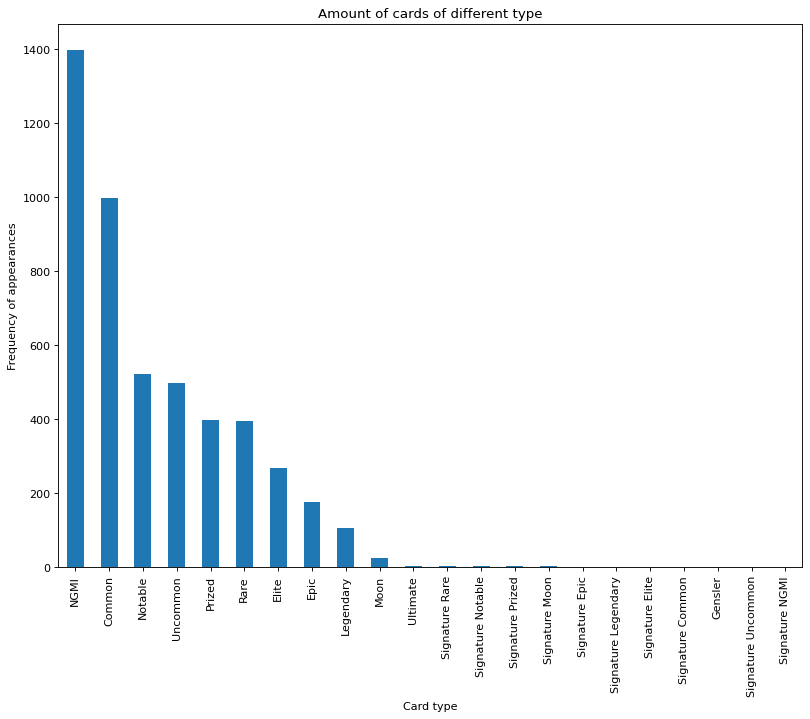

In [24]:
# Card types
plt.figure(figsize=(12, 9), dpi=80)
df_mint['Card Rarity'].value_counts().plot(kind='bar')
plt.xlabel("Card type")
plt.ylabel("Frequency of appearances")
plt.title("Amount of cards of different type")
plt.show()

In [25]:
df_mint['Card Rarity'].value_counts()

NGMI                   1399
Common                  999
Notable                 522
Uncommon                499
Prized                  397
Rare                    396
Elite                   268
Epic                    178
Legendary               106
Moon                     25
Ultimate                  5
Signature Rare            4
Signature Notable         3
Signature Prized          3
Signature Moon            3
Signature Epic            2
Signature Legendary       2
Signature Elite           2
Signature Common          1
Gensler                   1
Signature Uncommon        1
Signature NGMI            1
Name: Card Rarity, dtype: int64

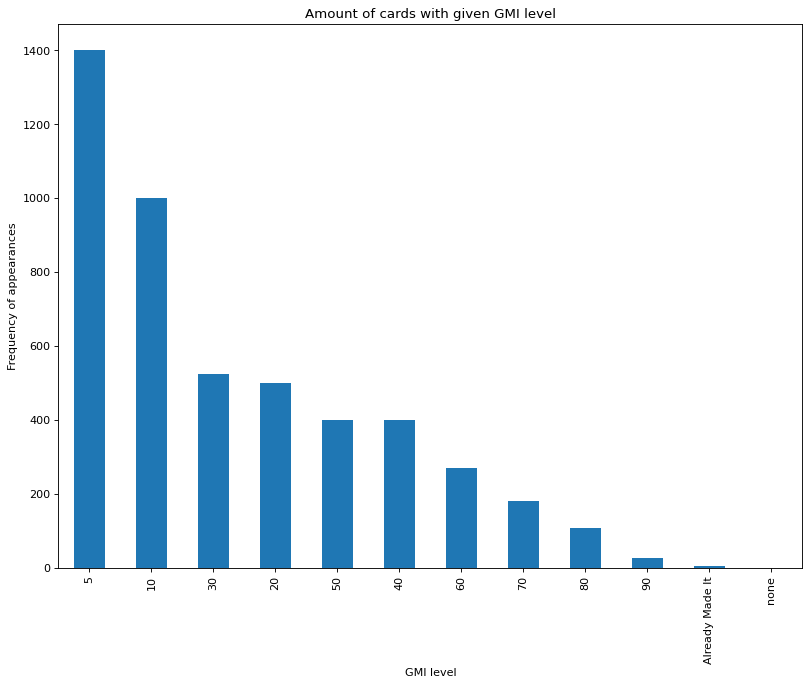

In [26]:
# GMI level
plt.figure(figsize=(12, 9), dpi=80)
df_mint['GMI Level'].value_counts().plot(kind='bar')
plt.xlabel("GMI level")
plt.ylabel("Frequency of appearances")
plt.title("Amount of cards with given GMI level")
plt.show()

In [27]:
df_mint['GMI Level'].value_counts()

5                  1400
10                 1000
30                  525
20                  500
50                  400
40                  400
60                  270
70                  180
80                  108
90                   28
Already Made It       5
none                  1
Name: GMI Level, dtype: int64

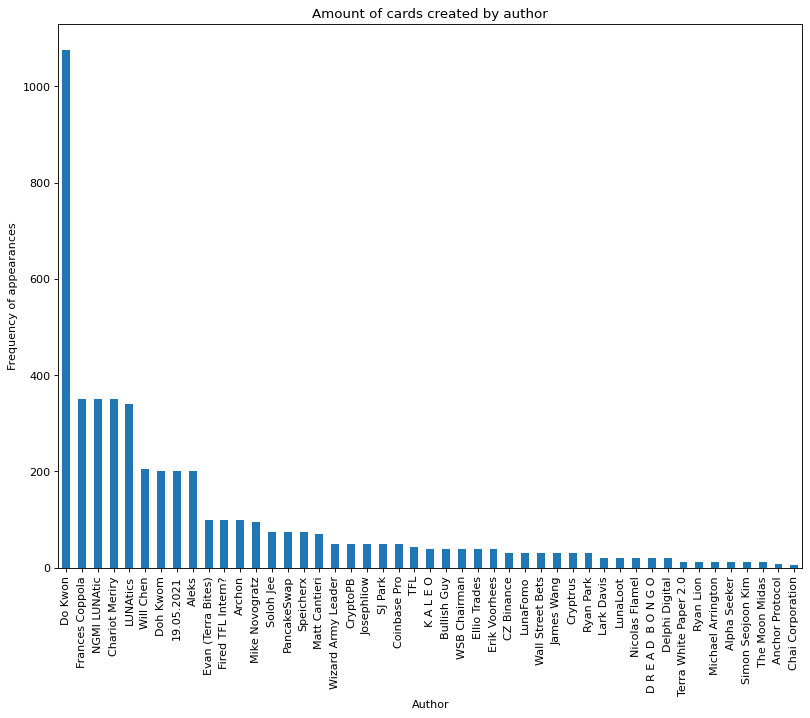

In [28]:
# Author
plt.figure(figsize=(12, 9), dpi=80)
df_mint['Author'].value_counts().plot(kind='bar')
plt.xlabel("Author")
plt.ylabel("Frequency of appearances")
plt.title("Amount of cards created by author")
plt.show()

In [29]:
df_mint['Author'].value_counts()

Do Kwon                  1075
Frances Coppola           350
NGMI LUNAtic              350
Chariot Meriry            350
LUNAtics                  340
Will Chen                 205
Doh Kwom                  200
19.05.2021                200
Aleks                     200
Evan (Terra Bites)        100
Fired TFL Intern?         100
Archon                    100
Mike Novogratz             95
Soloh Jee                  75
PancakeSwap                75
Speicherx                  75
Matt Cantieri              70
Wizard Army Leader         50
CryptoPB                   50
Josephliow                 50
SJ Park                    50
Coinbase Pro               50
TFL                        43
K A L E O                  40
Bullish Guy                40
WSB Chairman               40
Ellio Trades               40
Erik Voorhees              40
CZ Binance                 30
LunaFomo                   30
Wall Street Bets           30
James Wang                 30
Cryptrus                   30
Ryan Park 

### Checking if we have any lacks of data

In [30]:
df_mint.isna().sum()

token_id       0
name           0
description    0
Author         0
GMI Level      0
Card Rarity    0
Series         0
dtype: int64

In [31]:
df_mint['Series'].value_counts() #All cards are from the same series - Genesis

Genesis    4817
Name: Series, dtype: int64

### Analyzing rarity

Here we propose a way to evaluate the rarity of a given card based on their three non-identical features - author, GMI level, and type of a card. Base value will be evaluated as amount of all cards divided by amount of cards of given author/GMI level/type, since the smaller amount of cards of given characteristic, the more valuable it is, especially as the number of said cards decreases. After that, we will assign a weight to every cathegory - 0.1 to author, 0.5 to GMI level and 1 to type of a card.

In [32]:
Rarity = [0] * len(df_mint)
for i in range(len(df_mint)):
    Rarity[i] = 0.1*df_mint['Author'].value_counts().sum()/df_mint['Author'].value_counts()[df_mint.iloc[i]['Author']] + 0.5*df_mint['GMI Level'].value_counts().sum()/df_mint['GMI Level'].value_counts()[df_mint.iloc[i]['GMI Level']] + df_mint['Card Rarity'].value_counts().sum()/df_mint['Card Rarity'].value_counts()[df_mint.iloc[i]['Card Rarity']]

### Creating a ranking:

In [36]:
Ranking = sorted(range(len(Rarity)), key=lambda i: Rarity[i])[-len(Rarity):]
Ranking.reverse()
rank = 1
i = 0
for i in range(len(Ranking)):
    Ranking[i] = (Ranking[i], rank)
    rank = rank + 1

### Five rarest cards:

In [37]:
top5 = sorted(range(len(Rarity)), key=lambda i: Rarity[i])[-5:]
top5.reverse()
i = 1
for k in top5:
    print("Number " + str(i) + ': ')
    print(df_mint.iloc[k])
    i += 1

Number 1: 
token_id       58408018481038309739791512349687153464
name                                 Armageddon 01 #1
description                       Armageddon Protocol
Author                                            TFL
GMI Level                                        none
Card Rarity                                   Gensler
Series                                        Genesis
Name: 124, dtype: object
Number 2: 
token_id                  79352871591151301578275200992830815254
name                       SIGNED Mirror 03 - Disco Design v2 #1
description    I will do something about the boomers. Literal...
Author                                                   Do Kwon
GMI Level                                                     20
Card Rarity                                   Signature Uncommon
Series                                                   Genesis
Name: 2598, dtype: object
Number 3: 
token_id       52855928644102250105313865966348460708
name                SIGNED Mi

### Rarity ratings for all cards:

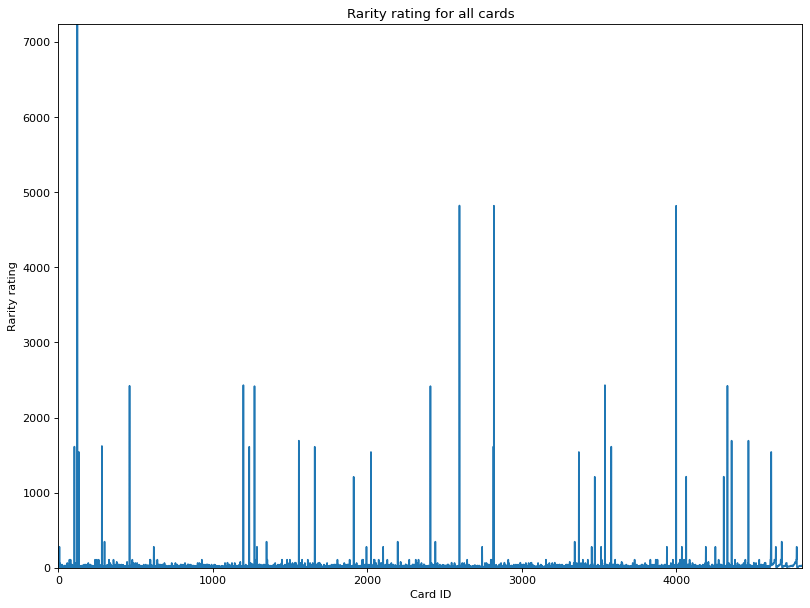

In [38]:
plt.figure(figsize=(12, 9), dpi=80)
plt.plot(Rarity)
plt.xlabel("Card ID")
plt.ylabel("Rarity rating")
plt.title("Rarity rating for all cards")
plt.xlim([0, len(df_mint)])
plt.ylim([0, max(Rarity)])
plt.show()

### Most often sold NFTs with their rarities

In [39]:
list_of_tokenids = list(df_mint.token_id) # list of token_id

In [40]:
rarities = {}
for i in range(len(Rarity)):
    rarities[list_of_tokenids[i]] = (Rarity[i]) # Dictionary of rarities by token_ids

### Most frequently sold NFTs:

In [41]:
transactions_info = dict(df_exec['token_id'].value_counts())
for i in transactions_info:
    print("Token_id: " + str(i), "Amount of transactions: " + str(transactions_info[i]), "Rarity: " + str(rarities[i]))

Token_id: 83113431201354405664000930754863969533 Amount of transactions: 3 Rarity: 64.52735330836454
Token_id: 281616437428915779377924868184696624039 Amount of transactions: 3 Rarity: 7.678414845077636
Token_id: 180998936536521118372014929895471494990 Amount of transactions: 2 Rarity: 27.788751259445846
Token_id: 199757267167817086568765726413818573313 Amount of transactions: 2 Rarity: 8.647086527704175
Token_id: 337657555891641562906082327351895323698 Amount of transactions: 2 Rarity: 6.539816552639641
Token_id: 180032492914383720543048580238272857886 Amount of transactions: 2 Rarity: 20.238255062944717
Token_id: 223142271087098502867805362882438439006 Amount of transactions: 2 Rarity: 9.638821821821821
Token_id: 178235536462909212424933542927454459313 Amount of transactions: 2 Rarity: 6.539816552639641
Token_id: 67627300405833552892261216987858507196 Amount of transactions: 2 Rarity: 6.539816552639641
Token_id: 185735124246838775479233843732148627311 Amount of transactions: 2 Rarity

### Average ratity based on amount of transactions:

In [42]:
avg_rarity = {1: 0, 2: 0, 3: 0}
amount_of_transactions = Counter(list(df_exec['token_id'].value_counts()))
for i in transactions_info:
    avg_rarity[transactions_info[i]] += rarities[i]/amount_of_transactions[transactions_info[i]]

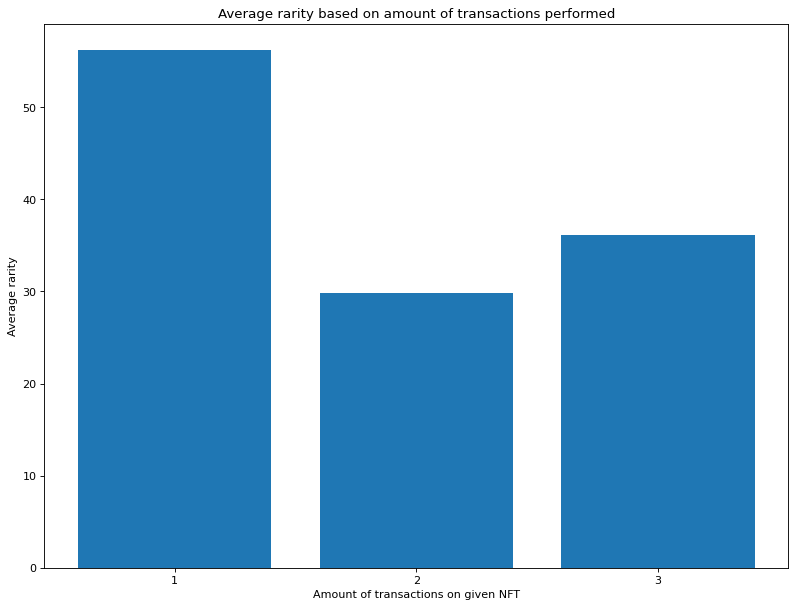

In [43]:
plt.figure(figsize=(12, 9), dpi=80)

plt.bar(range(len(avg_rarity)), avg_rarity.values(), align='center')
plt.xticks(range(len(avg_rarity)), list(avg_rarity.keys()))
plt.xlabel("Amount of transactions on given NFT")
plt.ylabel("Average rarity")
plt.title("Average rarity based on amount of transactions performed")

plt.show()

### NFTs prices

In [44]:
# Getting prices of nfts
nft_value = {}
for i in range(len(df_exec)):
    try:
        nft_value[list(df_exec['token_id'])[i]] += int(nft_value[list(df_exec['amount'])[i]])
    except:
        nft_value[list(df_exec['token_id'])[i]] = int(list(df_exec['amount'])[i])

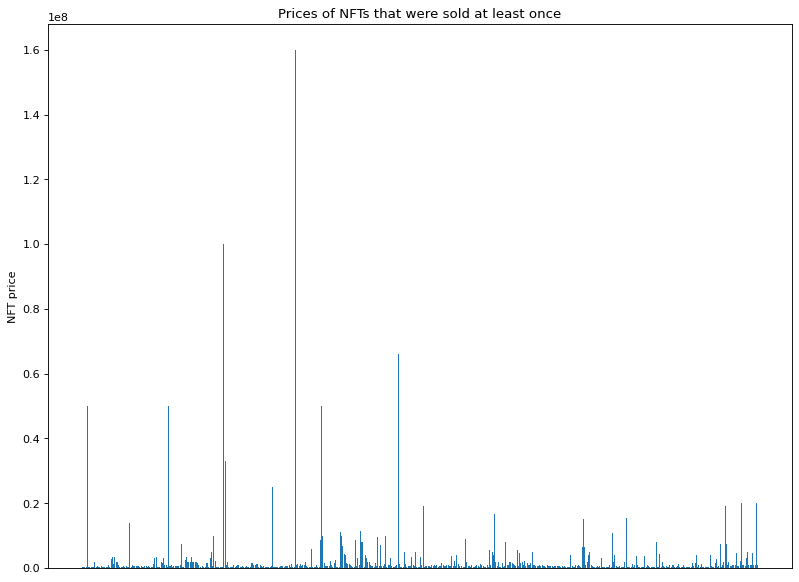

In [45]:
plt.figure(figsize=(12, 9), dpi=80)

plt.bar(range(len(nft_value)), nft_value.values(), align='center')
plt.xticks([], [])
plt.ylabel("NFT price")
plt.title("Prices of NFTs that were sold at least once")

plt.show()

In [46]:
# Assigning ranges
below_300000 = [i for i in list(df_exec['amount']) if int(i) < 300000]
below_one_luna = [i for i in list(df_exec['amount']) if int(i) >= 300000 and int(i) < 1000000]
equal_luna = [i for i in list(df_exec['amount']) if int(i) == 1000000]
more_than_luna = [i for i in list(df_exec['amount']) if int(i) > 1000000 and int(i) < 10000000]
more_than_10_lunas = [i for i in list(df_exec['amount']) if int(i) >= 10000000]

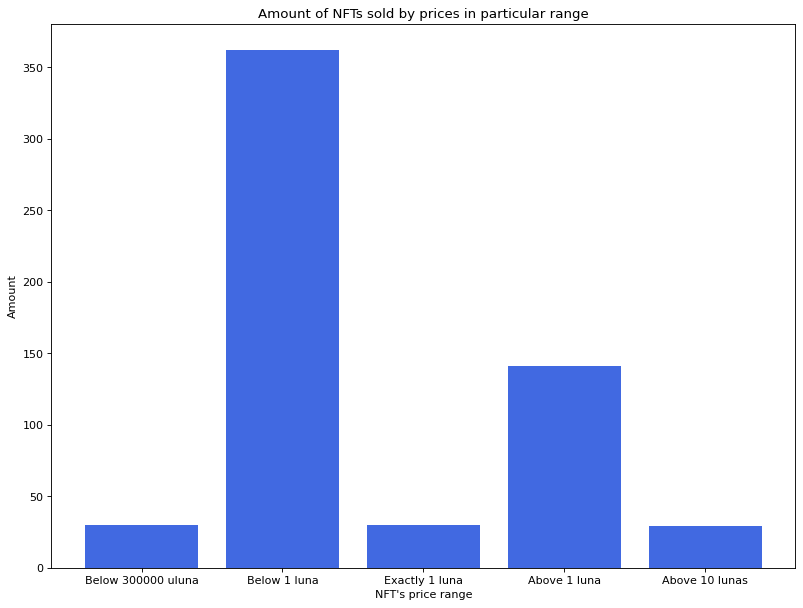

In [47]:
labels = ["Below 300000 uluna", "Below 1 luna", "Exactly 1 luna", "Above 1 luna", "Above 10 lunas"]
plt.figure(figsize=(12, 9), dpi=80)
price_values = [len(below_300000), len(below_one_luna), len(equal_luna), len(more_than_luna), len(more_than_10_lunas)]
for i in range(5):
    plt.bar(labels[i], price_values[i], color = 'royalblue')
plt.xlabel("NFT's price range")
plt.ylabel("Amount")
plt.title("Amount of NFTs sold by prices in particular range")
plt.show()